In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
from os import path
from glob import glob
import numpy as np
import matplotlib.pylab as plt

from se3cnn.point_utils import difference_matrix
from pao_file_utils import parse_pao_file, write_pao_file
from pao_tfn_dataset import encode_kind
from pao_tfn_trainer import train_pao_tfn, loss_function
from cp2k_file_utils import read_energy

In [4]:
# Load training data and hard code metadata.
pao_files = sorted(glob("2H2O_MD/frame_*/2H2O_pao44-1_0.pao"))

prim_basis_shells = {
    'H': [2, 1, 0], # two s-shells, one p-shell, no d-shells
    'O': [2, 2, 1], # two s-shells, two p-shells, one d-shell
}

pao_basis_size = 4

In [5]:
# Use the first few frames to train networks for Hydrogen and Oxygen.
train_params = dict(
    prim_basis_shells=prim_basis_shells,
    pao_basis_size=pao_basis_size,
    pao_files=pao_files[:10],  # number of frames used as training data
    num_hidden=1,              # number of hidden layers
    max_epochs=201,            # number of training epochs
)

net_H = train_pao_tfn(**train_params, kind_name="H")
net_O = train_pao_tfn(**train_params, kind_name="O")

Training NN for kind H using 40 samples.
Epoch:     0  Loss: 1.9293e-01
Epoch:    20  Loss: 1.5379e-02
Epoch:    40  Loss: 5.6790e-03
Epoch:    60  Loss: 4.1412e-03
Epoch:    80  Loss: 2.3343e-03
Epoch:   100  Loss: 1.5219e-03
Epoch:   120  Loss: 1.3653e-03
Epoch:   140  Loss: 1.3869e-03
Epoch:   160  Loss: 1.8025e-03
Epoch:   180  Loss: 4.6198e-04
Epoch:   200  Loss: 3.5138e-04
Training NN for kind O using 20 samples.
Epoch:     0  Loss: 7.6501e-02
Epoch:    20  Loss: 3.1888e-03
Epoch:    40  Loss: 1.0912e-04
Epoch:    60  Loss: 4.5908e-05
Epoch:    80  Loss: 3.3086e-05
Epoch:   100  Loss: 2.8310e-05
Epoch:   120  Loss: 1.8861e-05
Epoch:   140  Loss: 1.5635e-05
Epoch:   160  Loss: 3.1965e-05
Epoch:   180  Loss: 1.6162e-05
Epoch:   200  Loss: 7.5901e-06


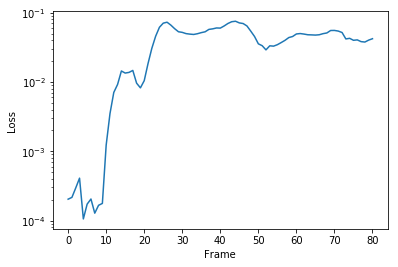

In [6]:
# Use the trained networks to inferre xblocks for all frames and calc their loss.
losses = []

for fn in pao_files:
    kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
    kind_onehot = encode_kind(atom2kind)
    natoms = coords.shape[0]
    losses.append(0.0)
    xblocks_inferred = []
    for iatom in range(natoms):
        kind_onehot_torch = torch.as_tensor(kind_onehot)[None,...]
        coords_torch = torch.as_tensor(coords)[None,...]
        diff_M = difference_matrix(coords_torch)
        if atom2kind[iatom] == "H":
            output_net = net_H(kind_onehot_torch, diff_M)
        elif atom2kind[iatom] == "O":
            output_net = net_O(kind_onehot_torch, diff_M)
        xblock_net = output_net[...,iatom]
        xblocks_inferred.append(xblock_net.detach().numpy()[0,...])
        loss = loss_function(xblock_net, torch.as_tensor(xblocks[iatom][None,...]))
        losses[-1] += loss.item() / natoms
    fn_inferred = path.dirname(fn) + "/inferred.pao"
    write_pao_file(fn_inferred, kinds, atom2kind, coords, xblocks_inferred)

plt.xlabel("Frame")
plt.ylabel("Loss")
plt.yscale('log')
plt.plot(losses);

In [7]:
# Run CP2K on a few of the inferred frames. DFT Energy difference below 1 milliHartree would be nice.
verify_frames = range(20)

for iframe in verify_frames:
    frame_dir = path.dirname(pao_files[iframe])
    ! cd $frame_dir; /opt/cp2k/exe/local/cp2k.ssmp -i 2H2O_pao44_inferred.inp > 2H2O_pao44_inferred.out
    pao_energy = read_energy(frame_dir+"/2H2O_pao44.out")
    pao_ml_energy = read_energy(frame_dir+"/2H2O_pao44_inferred.out")
    energy_diff = pao_ml_energy - pao_energy
    tmpl = "Frame: {} Dir: {} Loss: {:0.4e} Energy-diff: {:0.4e} Hartree"
    print(tmpl.format(iframe, frame_dir, losses[iframe], energy_diff))

Frame: 0 Dir: 2H2O_MD/frame_0000 Loss: 2.0314e-04 Energy-diff: 2.0269e-04 Hartree
Frame: 1 Dir: 2H2O_MD/frame_0025 Loss: 2.1587e-04 Energy-diff: 1.4332e-04 Hartree
Frame: 2 Dir: 2H2O_MD/frame_0050 Loss: 2.9522e-04 Energy-diff: 1.0279e-04 Hartree
Frame: 3 Dir: 2H2O_MD/frame_0075 Loss: 4.0869e-04 Energy-diff: 2.1890e-04 Hartree
Frame: 4 Dir: 2H2O_MD/frame_0100 Loss: 1.0548e-04 Energy-diff: 1.9513e-04 Hartree
Frame: 5 Dir: 2H2O_MD/frame_0125 Loss: 1.7247e-04 Energy-diff: 3.5048e-04 Hartree
Frame: 6 Dir: 2H2O_MD/frame_0150 Loss: 2.0432e-04 Energy-diff: 2.3278e-04 Hartree
Frame: 7 Dir: 2H2O_MD/frame_0175 Loss: 1.2771e-04 Energy-diff: 2.4107e-04 Hartree
Frame: 8 Dir: 2H2O_MD/frame_0200 Loss: 1.6585e-04 Energy-diff: 3.2508e-04 Hartree
Frame: 9 Dir: 2H2O_MD/frame_0225 Loss: 1.7653e-04 Energy-diff: 2.0421e-04 Hartree
Frame: 10 Dir: 2H2O_MD/frame_0250 Loss: 1.2261e-03 Energy-diff: 6.0252e-04 Hartree
Frame: 11 Dir: 2H2O_MD/frame_0275 Loss: 3.4890e-03 Energy-diff: 1.0070e-03 Hartree
Frame: 12 Dir: